# Sample extraction
The model will be focused on predicting overweight and obesity in children and adolescents from 5 to 19 years. 
The first step is to identify the size of n to use as sample for building the models and the metadata of the study population. The n will be taken from the CSV containing the anthropometric measures (CN_ANTROPOMETRIA) in the ENSANUT-18 database. The following steps are needed:
1. Filter down the age group
2. Filter down pregnant adolescents
3. Identify the 'not registered' values (222.2, 222.22, 222.222)
4. Calculate the averages of weight1/weight2 and height1/height2
5. Calculate the standard deviations (SD) according to the BMI-for-age z-scores tables of WHO
6. Assign the categorical labels "underweight", "normal", "overweight", and "obese" 
7. Know the distribution of the label
8. Export transformed CSV

## Setup

### Libraries

In [1019]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Paths

In [1020]:
# Audio features dataset
input_path = '../../0_source_csv/ensanut/'
input_path_z_scores = '../../0_source_csv/z_scores_who/'

# CSV output
output_path = '../output/'

# Global configuration path
glob_conf_path = '../../config/global_config_paper.py'

### Load global variables

In [1021]:
exec(open(glob_conf_path).read())

### Load and prepare datasets

Each row contains the following values that altogether form the unique household and person IDs:
- UPM: Sample Primary Unit, "Unidad Primaria de Muestreo" for its abbreviation in spanish
- VIV_SEL: Selected house, "Vivienda Seleccionada"
- HOGAR: Household identifier, "Household"
- NUMREN: Household member identifier, "Numero de residente"

Concatenated form:
- house_ID: (UPM+VIV_SEL)
- household_ID: (UPM+VIV_SEL+HOGAR) 
- person_ID: (UPM+VIV_SEL+HOGAR+NUMREN)

In [1022]:
# Load CSV
locality_size_df = pd.read_csv(os.path.join(input_path, "ponderadores_hipertension.csv"))

# Keep only the necessary columns 
locality_size_df = locality_size_df[["UPM","TLOC"]]

# Rename columns
locality_size_df = locality_size_df.rename(columns={"TLOC":"locality_size"})

# See statistical info of the data
locality_size_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17263 entries, 0 to 17262
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   UPM            17263 non-null  int64
 1   locality_size  17263 non-null  int64
dtypes: int64(2)
memory usage: 269.9 KB


In [1023]:
locality_size_df = locality_size_df.drop_duplicates(subset=["UPM"])
locality_size_df

,UPM,locality_size
0,1,1
3,2,1
4,3,1
7,4,1
9,6,1
...,...,...
17179,3934,4
17197,3935,4
17212,3936,4
17230,3937,4


In [1024]:
# Load CSV
anthropometry_df = pd.read_csv(os.path.join(input_path, "CN_ANTROPOMETRIA.csv"))

# Keep only the necessary columns 
sample = anthropometry_df[["UPM","VIV_SEL","HOGAR","NUMREN","REGION","ESTRATO","DOMINIO","P6","PESO1_1","PESO1_2",
                   "TALLA4_1","TALLA4_2","EDAD_MESES","SEXO"]]

# Rename columns
sample = sample.rename(columns={"REGION":"region", 
                                "ESTRATO":"strata",
                                "DOMINIO":"locality_type",
                                "P6":"pregnant", 
                                "PESO1_1":"weight1", 
                                "PESO1_2":"weight2",
                                "TALLA4_1":"height1",
                                "TALLA4_2":"height2",
                                "EDAD_MESES":"age_months",
                                "SEXO":"sex"})

# Replace data of categorical features
sample["region"] = sample["region"].replace([1,2,3,4],["North","Centre","Mexico City","South"])
sample["strata"] = sample["strata"].replace([1,2,3,4],["1st_strata","2nd_strata","3rd_strata","4th_strata"])
sample["locality_type"] = sample["locality_type"].replace([1,2],["urban","rural"])
sample["sex"] = sample["sex"].replace([1,2],["male","female"])

# Create unique identifiers
sample["house_ID"] = sample["UPM"].astype(str)+'_'+sample["VIV_SEL"].astype(str)
sample["household_ID"] = sample["UPM"].astype(str)+'_'+sample["VIV_SEL"].astype(str)+'_'+sample["HOGAR"].astype(str)
sample["person_ID"] = sample["UPM"].astype(str)+'_'+sample["VIV_SEL"].astype(str)+'_'+sample["HOGAR"].astype(str)+'_'+sample["NUMREN"].astype(str)

#Drop separated identifier columns
sample = sample.drop(columns=["VIV_SEL","HOGAR","NUMREN"])

# See statistical info of the data
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33818 entries, 0 to 33817
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UPM            33818 non-null  int64  
 1   region         33818 non-null  object 
 2   strata         33818 non-null  object 
 3   locality_type  33818 non-null  object 
 4   pregnant       8962 non-null   float64
 5   weight1        29685 non-null  float64
 6   weight2        29223 non-null  float64
 7   height1        29685 non-null  float64
 8   height2        29133 non-null  float64
 9   age_months     33818 non-null  int64  
 10  sex            33818 non-null  object 
 11  house_ID       33818 non-null  object 
 12  household_ID   33818 non-null  object 
 13  person_ID      33818 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 3.6+ MB


#### 1. Filter down the age group

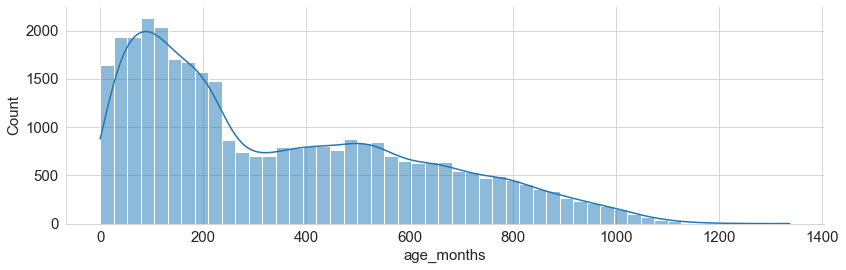

In [1025]:
# See distribution of age
age_dist = sns.displot(data=sample, x="age_months", kde=True, 
                       height=4, aspect=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11703 entries, 2 to 33816
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UPM            11703 non-null  int64  
 1   region         11703 non-null  object 
 2   strata         11703 non-null  object 
 3   locality_type  11703 non-null  object 
 4   pregnant       2611 non-null   float64
 5   weight1        11703 non-null  float64
 6   weight2        11525 non-null  float64
 7   height1        11703 non-null  float64
 8   height2        11510 non-null  float64
 9   age_months     11703 non-null  int64  
 10  sex            11703 non-null  object 
 11  house_ID       11703 non-null  object 
 12  household_ID   11703 non-null  object 
 13  person_ID      11703 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 1.6+ MB


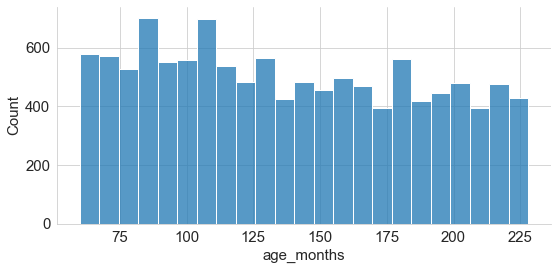

In [1026]:
#Keep only children and adolescents from 5 to 19 years old (60 to 228 months)
sample = sample[(sample.age_months >= 60) & (sample.age_months <= 228)]

#See new distribution of age
age_dist = sns.displot(data=sample, x="age_months",  
                       height=4, aspect=2)
sample.info()

In [1027]:
# Merge locality size column
sample = sample.merge(locality_size_df, on="UPM", how="left")

# Rename data
sample["locality_size"] = sample["locality_size"].replace([1.0,2.0,3.0,4.0],[">100,000","15,000-99,999","2,500-14,999","<2,500"])
del sample["UPM"]
sample

,region,strata,locality_type,pregnant,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size
0,Centre,3rd_strata,urban,NaN,28.40,28.50,136.4,136.4,122,female,1_4,1_4_1,1_4_1_8,">100,000"
1,Centre,2nd_strata,urban,4.0,48.45,48.55,157.8,157.8,149,female,3_2,3_2_1,3_2_1_5,">100,000"
2,Centre,2nd_strata,urban,NaN,48.45,48.45,173.2,173.3,202,male,3_4,3_4_1,3_4_1_5,">100,000"
3,Centre,2nd_strata,urban,NaN,80.15,80.10,175.3,175.4,162,male,4_1,4_1_1,4_1_1_4,">100,000"
4,Centre,2nd_strata,urban,NaN,73.10,73.15,169.5,169.5,197,male,4_3,4_3_1,4_3_1_5,">100,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11698,Centre,2nd_strata,rural,NaN,39.75,39.75,146.7,146.5,130,male,3938_17,3938_17_1,3938_17_1_3,"<2,500"
11699,Centre,2nd_strata,rural,NaN,34.00,33.95,136.2,136.5,119,female,3938_17,3938_17_1,3938_17_1_4,"<2,500"
11700,Centre,2nd_strata,rural,NaN,71.55,71.55,174.9,174.9,170,male,3938_19,3938_19_1,3938_19_1_3,"<2,500"
11701,Centre,2nd_strata,rural,NaN,21.30,21.30,121.0,121.0,89,female,3938_19,3938_19_1,3938_19_1_5,"<2,500"


#### 2. Filter down pregnant adolescents

4.0    2492
1.0      42
2.0      41
9.0      35
3.0       1
Name: pregnant, dtype: int64

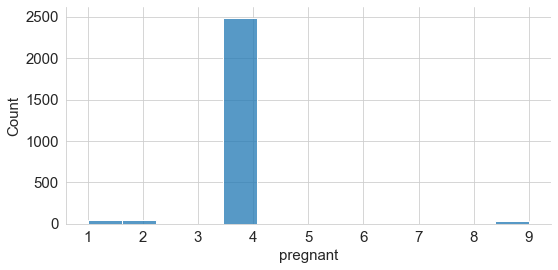

In [1028]:
# See pregnant distribution
preg_dist = sns.displot(data=sample, x="pregnant",  
                       height=4, aspect=2)

# Count values
sample.pregnant.value_counts()

In [1029]:
# Seems like a lot of values are missing, thefore all the nulls will be asumed to be not pregnant or male
sample.pregnant.isnull().sum()

9092

In [1030]:
# Verify existance of pregnant transgender people
sample.loc[((sample["pregnant"] != 4) & (sample["sex"] == "male") & (sample["pregnant"] > 0))]

,region,strata,locality_type,pregnant,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size


In [1031]:
# Define function to identify pregnant adolescents
def drop_pregnant_female(row):
    if (row['sex'] == "female"):            # if female
        if row['pregnant'] in [1,2,3,9]:    # if pregnant (1), breastfeeding (2), pregnant and breastfeeding (3), or does not know (9)
            return "pregnant"
        return "not pregnant"               # explicitly not pregnant
    return "male"                           # else male

In [1032]:
# Apply functions using lambdas
sample["pregnant"] = sample.apply(lambda row: drop_pregnant_female(row), axis=1)

In [1033]:
sample["pregnant"].value_counts()

male            5855
not pregnant    5729
pregnant         119
Name: pregnant, dtype: int64

In [1034]:
# Keep everything except pregnant
sample = sample[sample.pregnant != "pregnant"]

# See new description of database
sample["pregnant"].value_counts()

male            5855
not pregnant    5729
Name: pregnant, dtype: int64

In [1035]:
# Drop the "pregnant" column
del sample["pregnant"]

It can be observed that there are missing values in columns 'weight2' and 'height2', with slightly more missing values in 'height2'. Thus it is important to check for total percentage of missing values as well as the possible missing values in other columns.

In [1036]:
#Calculate the percentage of missing values
sample.isnull().mean()*100

region           0.000000
strata           0.000000
locality_type    0.000000
weight1          0.000000
weight2          1.424378
height1          0.000000
height2          1.553867
age_months       0.000000
sex              0.000000
house_ID         0.000000
household_ID     0.000000
person_ID        0.000000
locality_size    0.293508
dtype: float64

Percentage of missing values in 'height2' (which has the max number of missing values) is 1.65%, it could be related to a not registered value in 'height1' (same case for those NaN in 'weight2').

#### 3. Identify the 'not registered' values (222.2, 222.22, 222.222)

Values 222.2, 222.22, and 222.222 were used to signal that the selected person was not available or did not want to get their measurements taken.
- First a quick check of the rows with NaN values in 'height2' was done
- Then the columns were graphed to quickly identify the existence of such values. 
- All values >= 222 were dropped since:
    - no value was higher than 222 for any of the columns, so those were only 'not registered' values 
    - they only represented around 1-2%
    - a replace for the mean strategy would be complicated because of the high variability of heights in the 5 to 19 years population     

In [1037]:
#Check the rows with NaN values 
sample[sample["height2"].isnull()]

,region,strata,locality_type,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size
32,Centre,3rd_strata,urban,222.222,NaN,222.2,NaN,222,male,31_1,31_1_1,31_1_1_3,">100,000"
89,Centre,3rd_strata,urban,222.222,NaN,222.2,NaN,130,female,67_3,67_3_1,67_3_1_3,">100,000"
522,North,2nd_strata,urban,222.222,NaN,222.2,NaN,104,female,296_16,296_16_1,296_16_1_3,"15,000-99,999"
525,North,2nd_strata,urban,222.222,NaN,222.2,NaN,69,male,297_5,297_5_1,297_5_1_6,"15,000-99,999"
531,North,2nd_strata,urban,25.450,25.45,222.2,NaN,74,female,301_2,301_2_1,301_2_1_3,"2,500-14,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11535,Centre,2nd_strata,rural,222.222,NaN,222.2,NaN,199,male,3925_11,3925_11_1,3925_11_1_5,"<2,500"
11598,Centre,1st_strata,rural,222.222,NaN,222.2,NaN,139,male,3929_8,3929_8_1,3929_8_1_6,"<2,500"
11606,Centre,1st_strata,rural,222.222,NaN,222.2,NaN,179,male,3929_18,3929_18_1,3929_18_1_3,"<2,500"
11641,Centre,2nd_strata,rural,21.700,21.70,222.2,NaN,83,female,3932_20,3932_20_1,3932_20_1_5,"<2,500"


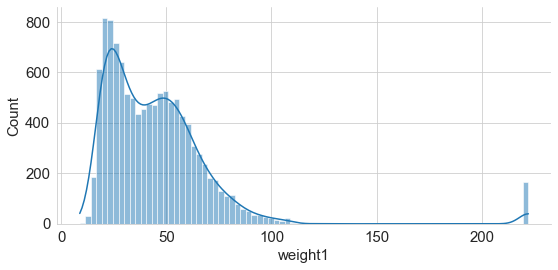

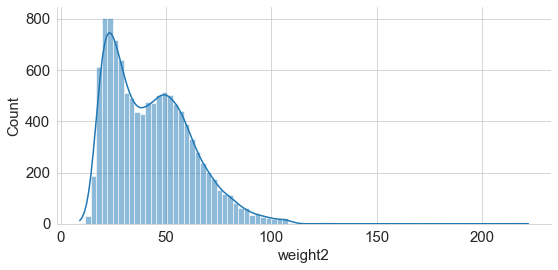

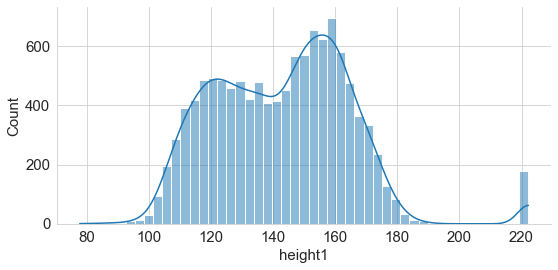

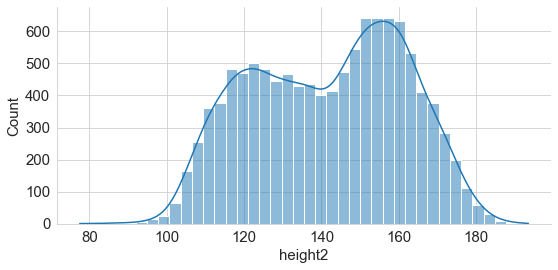

In [1038]:
#Look for "not registered" values in each column (>=222, <223)
sns.displot(data=sample, x="weight1", kde=True, height=4, aspect=2)
sns.displot(data=sample, x="weight2", kde=True, height=4, aspect=2)
sns.displot(data=sample, x="height1", kde=True, height=4, aspect=2)
sns.displot(data=sample, x="height2", kde=True, height=4, aspect=2)

,weight1,weight2,height1,height2,age_months
count,11381.000000,11381.000000,11381.000000,11381.000000,11381.000000
mean,42.629441,42.630811,141.497505,141.502328,137.802478
std,19.176598,19.176681,19.852553,19.853887,48.217826
min,8.800000,8.900000,77.800000,77.500000,60.000000
25%,26.000000,26.000000,124.500000,124.500000,96.000000
50%,40.320000,40.350000,143.500000,143.500000,134.000000
75%,55.500000,55.550000,157.800000,157.800000,179.000000
max,158.400000,158.400000,193.300000,193.500000,228.000000


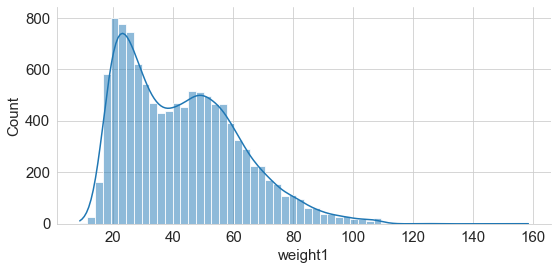

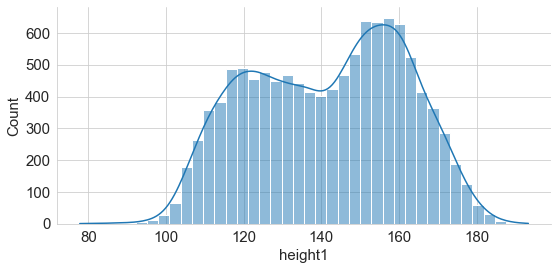

In [1039]:
#Keep only weight1 values <222 
sample = sample[(sample.weight1 < 222)]
age_dist = sns.displot(data=sample, x="weight1", kde=True, 
                       height=4, aspect=2)

#Keep only height1 values <222 
sample = sample[(sample.height1 < 222)]
age_dist = sns.displot(data=sample, x="height1", kde=True, 
                       height=4, aspect=2)

#Check new statistics
sample.describe()

In [1040]:
#Verify that there are no more NaN values
sample.isnull().sum()

region            0
strata            0
locality_type     0
weight1           0
weight2           0
height1           0
height2           0
age_months        0
sex               0
house_ID          0
household_ID      0
person_ID         0
locality_size    34
dtype: int64

#### 4. Calculate the averages of weight1/weight2 and height1/height2

In [1041]:
#Create a new column with the averages of weight and height
sample["av_weight"] = sample[["weight1", "weight2"]].mean(axis=1)
sample["av_height"] = sample[["height1", "height2"]].mean(axis=1)

#Reset the index
sample.reset_index(drop=True, inplace=True)
sample

,region,strata,locality_type,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size,av_weight,av_height
0,Centre,3rd_strata,urban,28.40,28.50,136.4,136.4,122,female,1_4,1_4_1,1_4_1_8,">100,000",28.450,136.40
1,Centre,2nd_strata,urban,48.45,48.55,157.8,157.8,149,female,3_2,3_2_1,3_2_1_5,">100,000",48.500,157.80
2,Centre,2nd_strata,urban,48.45,48.45,173.2,173.3,202,male,3_4,3_4_1,3_4_1_5,">100,000",48.450,173.25
3,Centre,2nd_strata,urban,80.15,80.10,175.3,175.4,162,male,4_1,4_1_1,4_1_1_4,">100,000",80.125,175.35
4,Centre,2nd_strata,urban,73.10,73.15,169.5,169.5,197,male,4_3,4_3_1,4_3_1_5,">100,000",73.125,169.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11376,Centre,2nd_strata,rural,39.75,39.75,146.7,146.5,130,male,3938_17,3938_17_1,3938_17_1_3,"<2,500",39.750,146.60
11377,Centre,2nd_strata,rural,34.00,33.95,136.2,136.5,119,female,3938_17,3938_17_1,3938_17_1_4,"<2,500",33.975,136.35
11378,Centre,2nd_strata,rural,71.55,71.55,174.9,174.9,170,male,3938_19,3938_19_1,3938_19_1_3,"<2,500",71.550,174.90
11379,Centre,2nd_strata,rural,21.30,21.30,121.0,121.0,89,female,3938_19,3938_19_1,3938_19_1_5,"<2,500",21.300,121.00


#### 5. Calculate the standard deviations (SD) according to the BMI-for-age z-scores tables of WHO

In [1042]:
#Import z-score reference tables from WHO
girls_zscores = pd.read_csv(os.path.join(input_path_z_scores,"bmi-girls-z-who-2007-exp.csv"))
boys_zscores = pd.read_csv(os.path.join(input_path_z_scores,"bmi-boys-z-who-2007-exp.csv"))

#Calculate BMI
sample["BMI"] = (sample["av_weight"]/(sample["av_height"]*0.01)**2)

In [1043]:
#Function for calculating BMI-for-age z-scores.
def calculate_bmi_z_score(BMI:float, age_m:int, sex:object):
    """Calculates the BMI-for-age for children and adolescents from 5 to 19 years based on the 
    z-score gendered tables defined by the World Health Organization (WHO). 
    Available: https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age.
    Returns the number of Standard Deviations (SD) of the BMI-for-age.
    Arguments:
    - BMI: body mass index,
    - age_m: age in months,
    - sex: categorical gender male and female."""
    #The WHO tables do not include 60 exact months (5 exact years), hemce the +=1
    if age_m ==60:
        age_m += 1
    
    #Take the index of the corresponding age in months
    idx = boys_zscores.index[boys_zscores["Month"] == age_m]
    
    #Take the corresponding L, M and S constants from the z-scores tables based on gender and age in months.
    if sex == "male":
        L = boys_zscores.loc[idx].get("L").item()
        M = boys_zscores.loc[idx].get("M").item()
        S = boys_zscores.loc[idx].get("S").item()
    
    if sex == "female":
        L = girls_zscores.loc[idx].get("L").item()
        M = girls_zscores.loc[idx].get("M").item()
        S = girls_zscores.loc[idx].get("S").item() 
        
    #Calculate SD
    return (((BMI / M) ** L) -1) / (S * L)

In [1044]:
#Function uses a list comprehension expression to go through a database and calculate bmi-for-age z-score.
def list_comp_BMI(df):
      return pd.Series([
    calculate_bmi_z_score(BMI, months, sex)
    for (BMI, months, sex) in zip(df["BMI"], df["age_months"], df["sex"])
  ])
  
sample["BMI_SD"] = list_comp_BMI(sample)
sample

,region,strata,locality_type,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size,av_weight,av_height,BMI,BMI_SD
0,Centre,3rd_strata,urban,28.40,28.50,136.4,136.4,122,female,1_4,1_4_1,1_4_1_8,">100,000",28.450,136.40,15.291621,-0.765584
1,Centre,2nd_strata,urban,48.45,48.55,157.8,157.8,149,female,3_2,3_2_1,3_2_1_5,">100,000",48.500,157.80,19.477255,0.438604
2,Centre,2nd_strata,urban,48.45,48.45,173.2,173.3,202,male,3_4,3_4_1,3_4_1_5,">100,000",48.450,173.25,16.141627,-2.465965
3,Centre,2nd_strata,urban,80.15,80.10,175.3,175.4,162,male,4_1,4_1_1,4_1_1_4,">100,000",80.125,175.35,26.058925,2.133956
4,Centre,2nd_strata,urban,73.10,73.15,169.5,169.5,197,male,4_3,4_3_1,4_3_1_5,">100,000",73.125,169.50,25.452267,1.413755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11376,Centre,2nd_strata,rural,39.75,39.75,146.7,146.5,130,male,3938_17,3938_17_1,3938_17_1_3,"<2,500",39.750,146.60,18.495633,0.781420
11377,Centre,2nd_strata,rural,34.00,33.95,136.2,136.5,119,female,3938_17,3938_17_1,3938_17_1_4,"<2,500",33.975,136.35,18.274655,0.744382
11378,Centre,2nd_strata,rural,71.55,71.55,174.9,174.9,170,male,3938_19,3938_19_1,3938_19_1_3,"<2,500",71.550,174.90,23.389989,1.403523
11379,Centre,2nd_strata,rural,21.30,21.30,121.0,121.0,89,female,3938_19,3938_19_1,3938_19_1_5,"<2,500",21.300,121.00,14.548187,-0.603178


#### 6. Assign the categorical labels "underweight", "normal", "overweight", and "obese" 

Interpretation of cutoffs
- Obesity: > +2SD (equivalent to BMI 30 kg/m2 at 19 years)
- Overweight: > +1SD (equivalent to BMI 25 kg/m2 at 19 years)
- Normal: between > -1SD and <+1SD
- Underweight: < -1SD
- Thinness: < -2SD
- Severe thinness: < -3SD

In [1045]:
#Function for returning the interpretation of cuttoffs based on the number of standard deviations (SD).
def interpret_BMI_z_score(SD:float):
    """Returns the BMI interpretation based on the number of Standard Deviations (SD) from the z-scores
    according to gender calculated from the BMI-for-age tables for children and adolescents from 
    5 to 19 years by the World Health Organization (WHO). 
    Available: https://www.who.int/tools/growth-reference-data-for-5to19-years/indicators/bmi-for-age.
    Argument:
    - SD: standard deviation calculated from the z-score tables.
    """
    #Assign label
    if (SD < -1.0):
         SD_label = "Underweight"
    if (SD < 1.0) & (SD >= -1.0):
        SD_label = "Normal"
    if (SD >= 1.0) & (SD < 2.0):
        SD_label = "Overweight"
    if (SD >= 2.0):
        SD_label = "Obese"
    return SD_label

In [1046]:
#Function uses a list comprehension expression to go through a database and return the SD interpretation.
def list_comp_SD(df):
    return pd.Series([
    interpret_BMI_z_score(SD)
    for (SD) in (df["BMI_SD"])
  ])
  
sample["SD_label"] = list_comp_SD(sample)
sample

,region,strata,locality_type,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size,av_weight,av_height,BMI,BMI_SD,SD_label
0,Centre,3rd_strata,urban,28.40,28.50,136.4,136.4,122,female,1_4,1_4_1,1_4_1_8,">100,000",28.450,136.40,15.291621,-0.765584,Normal
1,Centre,2nd_strata,urban,48.45,48.55,157.8,157.8,149,female,3_2,3_2_1,3_2_1_5,">100,000",48.500,157.80,19.477255,0.438604,Normal
2,Centre,2nd_strata,urban,48.45,48.45,173.2,173.3,202,male,3_4,3_4_1,3_4_1_5,">100,000",48.450,173.25,16.141627,-2.465965,Underweight
3,Centre,2nd_strata,urban,80.15,80.10,175.3,175.4,162,male,4_1,4_1_1,4_1_1_4,">100,000",80.125,175.35,26.058925,2.133956,Obese
4,Centre,2nd_strata,urban,73.10,73.15,169.5,169.5,197,male,4_3,4_3_1,4_3_1_5,">100,000",73.125,169.50,25.452267,1.413755,Overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11376,Centre,2nd_strata,rural,39.75,39.75,146.7,146.5,130,male,3938_17,3938_17_1,3938_17_1_3,"<2,500",39.750,146.60,18.495633,0.781420,Normal
11377,Centre,2nd_strata,rural,34.00,33.95,136.2,136.5,119,female,3938_17,3938_17_1,3938_17_1_4,"<2,500",33.975,136.35,18.274655,0.744382,Normal
11378,Centre,2nd_strata,rural,71.55,71.55,174.9,174.9,170,male,3938_19,3938_19_1,3938_19_1_3,"<2,500",71.550,174.90,23.389989,1.403523,Overweight
11379,Centre,2nd_strata,rural,21.30,21.30,121.0,121.0,89,female,3938_19,3938_19_1,3938_19_1_5,"<2,500",21.300,121.00,14.548187,-0.603178,Normal


#### 7. Know the distribution of the label

In [1047]:
# First, check for NaN values
sample.isna().mean()*100

region           0.000000
strata           0.000000
locality_type    0.000000
weight1          0.000000
weight2          0.000000
height1          0.000000
height2          0.000000
age_months       0.000000
sex              0.000000
house_ID         0.000000
household_ID     0.000000
person_ID        0.000000
locality_size    0.298744
av_weight        0.000000
av_height        0.000000
BMI              0.000000
BMI_SD           0.000000
SD_label         0.000000
dtype: float64

In [1048]:
# Drop NaN values and count again
sample = sample.dropna()
sample.isna().mean()*100

region           0.0
strata           0.0
locality_type    0.0
weight1          0.0
weight2          0.0
height1          0.0
height2          0.0
age_months       0.0
sex              0.0
house_ID         0.0
household_ID     0.0
person_ID        0.0
locality_size    0.0
av_weight        0.0
av_height        0.0
BMI              0.0
BMI_SD           0.0
SD_label         0.0
dtype: float64

count    11347.000000
mean         0.656040
std          1.339330
min        -12.182000
25%         -0.253800
50%          0.603735
75%          1.574348
max          7.731513
Name: BMI_SD, dtype: float64

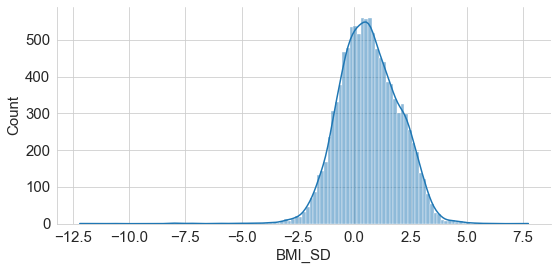

In [1049]:
SD_dist = sns.displot(data=sample, x="BMI_SD", kde=True, 
                       height=4, aspect=2)
sample["BMI_SD"].describe()

In [1050]:
#Keep only children and adolescents from -7.5 to 7.5 SD
sample = sample[(sample.BMI_SD >= -7.5) & (sample.BMI_SD <= 7.5)]
print("SD >= -7.5 & <= 7.5   n = ", len(sample))

#Keep only children and adolescents from -5.0 to 5.0 SD
sample = sample[(sample.BMI_SD >= -5.0) & (sample.BMI_SD <= 5.0)]
print("SD >= -5.0 & <= 5.0   n = ", len(sample))

SD >= -7.5 & <= 7.5   n =  11339
SD >= -5.0 & <= 5.0   n =  11320


count    11320.000000
mean         0.663530
std          1.294334
min         -4.759511
25%         -0.250158
50%          0.604540
75%          1.573164
max          4.992296
Name: BMI_SD, dtype: float64

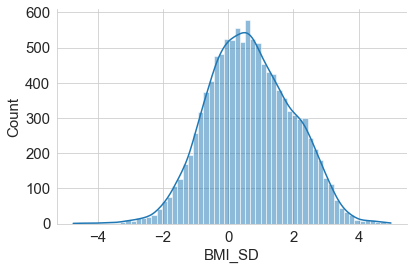

In [1051]:
SD_dist = sns.displot(data=sample, x="BMI_SD", kde=True, 
                       height=4, aspect=1.5)
sample["BMI_SD"].describe()

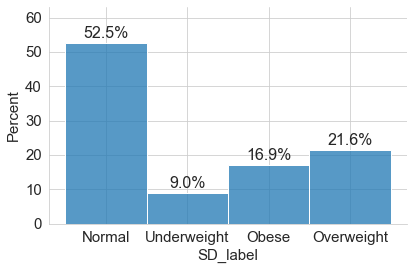

In [1052]:
# See label count
SD_dist = sns.displot(data=sample, x="SD_label", 
                       height=4, aspect=1.5, stat="percent")
show_label_percent(SD_dist)
plt.show()

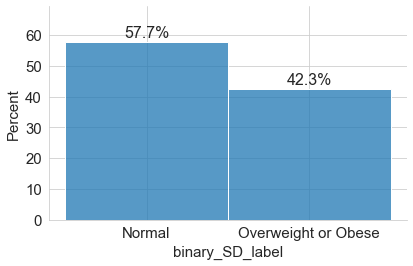

In [1053]:
# Evaluate balance of binary label
# Drop "Underweight" and create binary classes
sample_binary = sample.copy()
sample_binary.drop(sample_binary.loc[sample_binary['SD_label']=='Underweight'].index, inplace=True)
sample_binary["binary_SD_label"] = sample_binary["SD_label"].replace(["Overweight","Obese"],"Overweight or Obese")

# See counts of binary labels
binary_SD_dist = sns.displot(data=sample_binary, x="binary_SD_label", 
                       height=4, aspect=1.5, stat="percent")

show_label_percent(binary_SD_dist)

plt.show()

A binary classification of either normal or overweight or obese provides a better class balance, therefore "Underweight" population will be removed and the label will be transformed into:
- 1: Overweight or Obese
- 0: Normal weight

In [1054]:
# Drop "Underweight"
sample.drop(sample.loc[sample['SD_label']=='Underweight'].index, inplace=True)

# Create binary classification, categorical and numerical colum
sample["label_cat"] = sample["SD_label"].replace(["Overweight","Obese"],"Overweight or Obese")
sample["label"] = sample_binary["binary_SD_label"].replace(["Overweight or Obese","Normal"], [1,0])
sample.head()

,region,strata,locality_type,weight1,weight2,height1,height2,age_months,sex,house_ID,household_ID,person_ID,locality_size,av_weight,av_height,BMI,BMI_SD,SD_label,label_cat,label
0,Centre,3rd_strata,urban,28.40,28.50,136.4,136.4,122,female,1_4,1_4_1,1_4_1_8,">100,000",28.450,136.40,15.291621,-0.765584,Normal,Normal,0
1,Centre,2nd_strata,urban,48.45,48.55,157.8,157.8,149,female,3_2,3_2_1,3_2_1_5,">100,000",48.500,157.80,19.477255,0.438604,Normal,Normal,0
3,Centre,2nd_strata,urban,80.15,80.10,175.3,175.4,162,male,4_1,4_1_1,4_1_1_4,">100,000",80.125,175.35,26.058925,2.133956,Obese,Overweight or Obese,1
4,Centre,2nd_strata,urban,73.10,73.15,169.5,169.5,197,male,4_3,4_3_1,4_3_1_5,">100,000",73.125,169.50,25.452267,1.413755,Overweight,Overweight or Obese,1
5,Centre,2nd_strata,urban,79.20,79.25,170.8,170.7,169,male,4_5,4_5_1,4_5_1_5,">100,000",79.225,170.75,27.173202,2.209562,Obese,Overweight or Obese,1


n =  10301


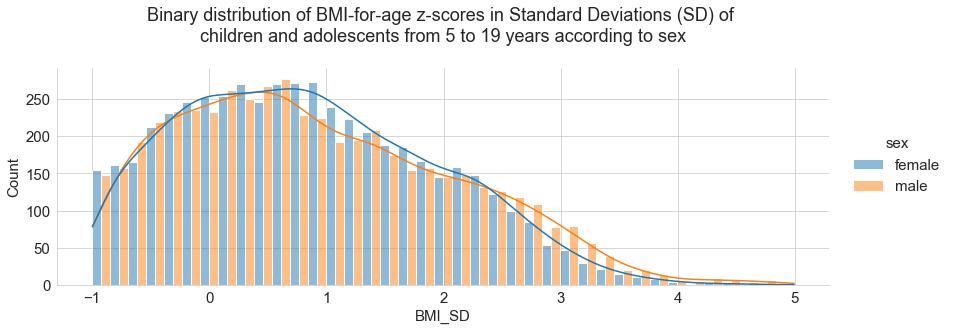

In [1055]:
# Plot distribution of sample with binary classes
SD_dist = sns.displot(data=sample, x="BMI_SD", hue="sex", multiple="dodge",  kde=True, 
                       height=4, aspect=3).set(title="""Binary distribution of BMI-for-age z-scores in Standard Deviations (SD) of 
children and adolescents from 5 to 19 years according to sex
""")
print("n = ",len(sample))

n =  10301


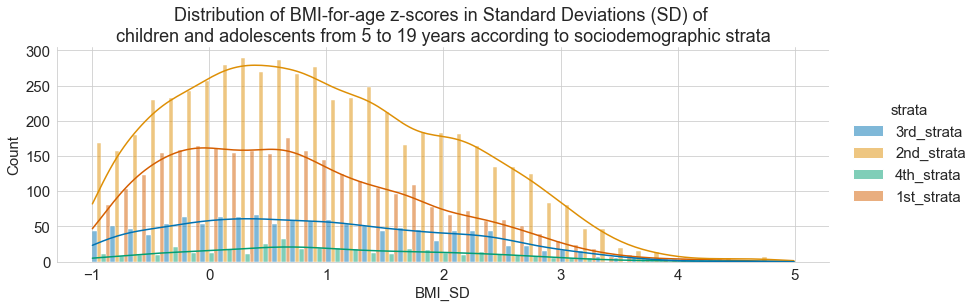

In [1056]:
# Plot distribution of sample with binary classes
SD_dist = sns.displot(data=sample, x="BMI_SD", hue="strata", palette="colorblind", multiple="dodge",  kde=True, 
                       height=4, aspect=3).set(title="""Distribution of BMI-for-age z-scores in Standard Deviations (SD) of 
children and adolescents from 5 to 19 years according to sociodemographic strata""")
print("n = ",len(sample))

n =  10301


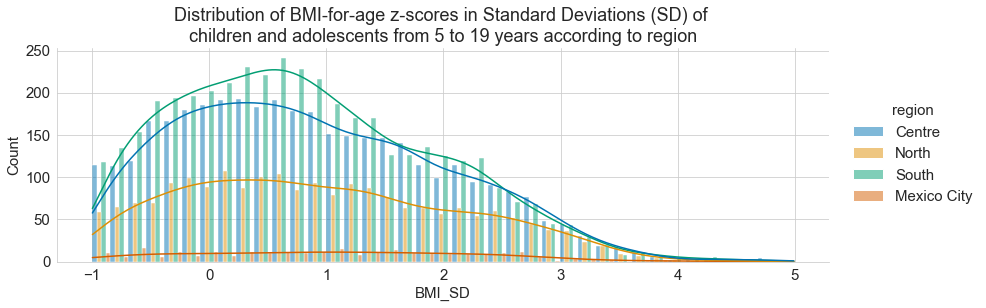

In [1057]:
# Plot distribution of sample with binary classes
SD_dist = sns.displot(data=sample, x="BMI_SD", hue="region", palette="colorblind", multiple="dodge",  kde=True, 
                       height=4, aspect=3).set(title="""Distribution of BMI-for-age z-scores in Standard Deviations (SD) of 
children and adolescents from 5 to 19 years according to region""")
print("n = ",len(sample))

n =  10301


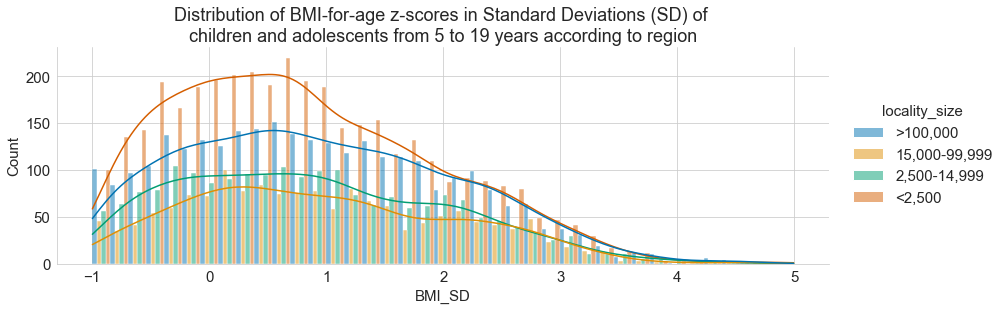

In [1058]:
# Plot distribution of sample with binary classes
SD_dist = sns.displot(data=sample, x="BMI_SD", hue="locality_size", palette="colorblind", multiple="dodge",  kde=True, 
                       height=4, aspect=3).set(title="""Distribution of BMI-for-age z-scores in Standard Deviations (SD) of 
children and adolescents from 5 to 19 years according to region""")
print("n = ",len(sample))

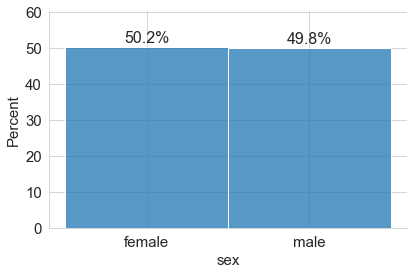

In [1059]:
# See demographic metadata
sex_dist = sns.displot(data=sample, x="sex", 
                       height=4, aspect=1.5, stat="percent")
show_label_percent(sex_dist)

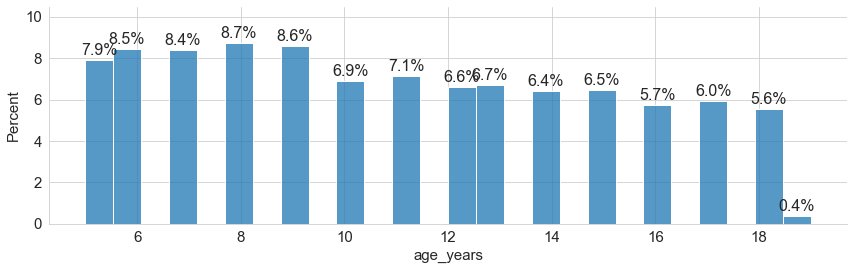

In [1060]:
# See demographic metadata
sample["age_years"] =(sample["age_months"]/12).astype(int)

age_dist = sns.displot(data=sample, x="age_years", 
                       height=4, aspect=3, stat="percent")
show_label_percent(age_dist)

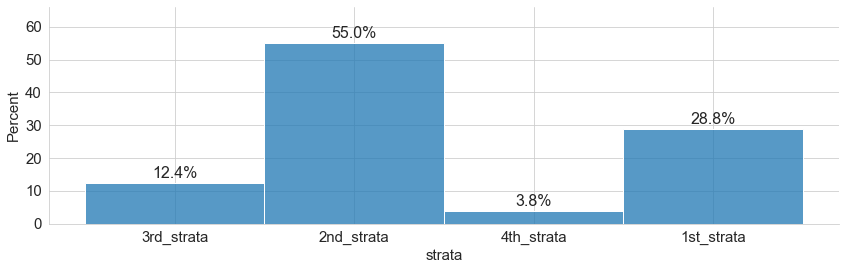

In [1061]:
# See demographic metadata
strata_dist = sns.displot(data=sample, x="strata", 
                       height=4, aspect=3, stat="percent")
show_label_percent(strata_dist)

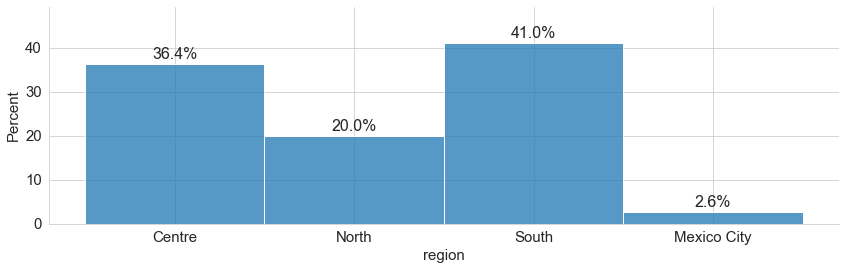

In [1062]:
# See demographic metadata
region_dist = sns.displot(data=sample, x="region", 
                       height=4, aspect=3, stat="percent")
show_label_percent(region_dist)

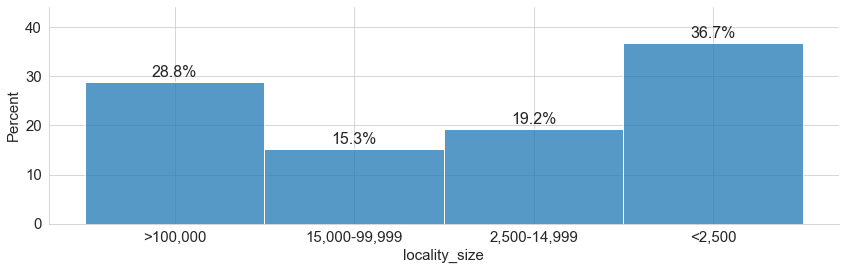

In [1063]:
# See demographic metadata
loc_size_dist = sns.displot(data=sample, x="locality_size", 
                       height=4, aspect=3, stat="percent")
show_label_percent(loc_size_dist)

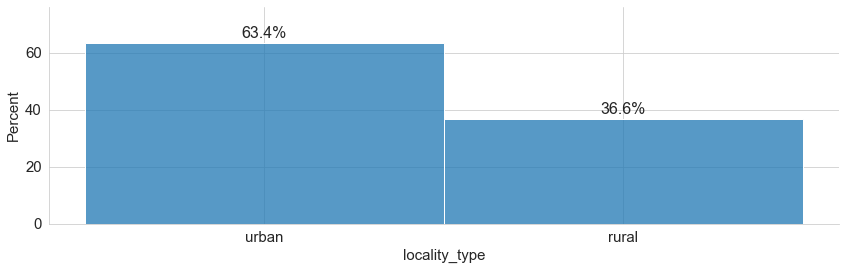

In [1064]:
# See demographic metadata
loc_type_dist = sns.displot(data=sample, x="locality_type", 
                       height=4, aspect=3, stat="percent")
show_label_percent(loc_type_dist)

#### 8. Export transformed CSV

In [1065]:
sample

,region,strata,locality_type,weight1,weight2,height1,height2,age_months,sex,house_ID,...,person_ID,locality_size,av_weight,av_height,BMI,BMI_SD,SD_label,label_cat,label,age_years
0,Centre,3rd_strata,urban,28.40,28.50,136.4,136.4,122,female,1_4,...,1_4_1_8,">100,000",28.450,136.40,15.291621,-0.765584,Normal,Normal,0,10
1,Centre,2nd_strata,urban,48.45,48.55,157.8,157.8,149,female,3_2,...,3_2_1_5,">100,000",48.500,157.80,19.477255,0.438604,Normal,Normal,0,12
3,Centre,2nd_strata,urban,80.15,80.10,175.3,175.4,162,male,4_1,...,4_1_1_4,">100,000",80.125,175.35,26.058925,2.133956,Obese,Overweight or Obese,1,13
4,Centre,2nd_strata,urban,73.10,73.15,169.5,169.5,197,male,4_3,...,4_3_1_5,">100,000",73.125,169.50,25.452267,1.413755,Overweight,Overweight or Obese,1,16
5,Centre,2nd_strata,urban,79.20,79.25,170.8,170.7,169,male,4_5,...,4_5_1_5,">100,000",79.225,170.75,27.173202,2.209562,Obese,Overweight or Obese,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11376,Centre,2nd_strata,rural,39.75,39.75,146.7,146.5,130,male,3938_17,...,3938_17_1_3,"<2,500",39.750,146.60,18.495633,0.781420,Normal,Normal,0,10
11377,Centre,2nd_strata,rural,34.00,33.95,136.2,136.5,119,female,3938_17,...,3938_17_1_4,"<2,500",33.975,136.35,18.274655,0.744382,Normal,Normal,0,9
11378,Centre,2nd_strata,rural,71.55,71.55,174.9,174.9,170,male,3938_19,...,3938_19_1_3,"<2,500",71.550,174.90,23.389989,1.403523,Overweight,Overweight or Obese,1,14
11379,Centre,2nd_strata,rural,21.30,21.30,121.0,121.0,89,female,3938_19,...,3938_19_1_5,"<2,500",21.300,121.00,14.548187,-0.603178,Normal,Normal,0,7


In [1066]:
# Create copy
sample_dataset = sample.copy()

# Delete unnecessary columns
del sample_dataset["weight1"]
del sample_dataset["weight2"]
del sample_dataset["height1"]
del sample_dataset["height2"]
del sample_dataset["av_weight"]
del sample_dataset["av_height"]
del sample_dataset["BMI"]
del sample_dataset["SD_label"]

sample_dataset

,region,strata,locality_type,age_months,sex,house_ID,household_ID,person_ID,locality_size,BMI_SD,label_cat,label,age_years
0,Centre,3rd_strata,urban,122,female,1_4,1_4_1,1_4_1_8,">100,000",-0.765584,Normal,0,10
1,Centre,2nd_strata,urban,149,female,3_2,3_2_1,3_2_1_5,">100,000",0.438604,Normal,0,12
3,Centre,2nd_strata,urban,162,male,4_1,4_1_1,4_1_1_4,">100,000",2.133956,Overweight or Obese,1,13
4,Centre,2nd_strata,urban,197,male,4_3,4_3_1,4_3_1_5,">100,000",1.413755,Overweight or Obese,1,16
5,Centre,2nd_strata,urban,169,male,4_5,4_5_1,4_5_1_5,">100,000",2.209562,Overweight or Obese,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11376,Centre,2nd_strata,rural,130,male,3938_17,3938_17_1,3938_17_1_3,"<2,500",0.781420,Normal,0,10
11377,Centre,2nd_strata,rural,119,female,3938_17,3938_17_1,3938_17_1_4,"<2,500",0.744382,Normal,0,9
11378,Centre,2nd_strata,rural,170,male,3938_19,3938_19_1,3938_19_1_3,"<2,500",1.403523,Overweight or Obese,1,14
11379,Centre,2nd_strata,rural,89,female,3938_19,3938_19_1,3938_19_1_5,"<2,500",-0.603178,Normal,0,7


In [1068]:
# Rearrange columns
sample_dataset = sample_dataset[['house_ID', 'household_ID', 'person_ID',
                                  'region','strata','locality_type','locality_size',
                                  'age_months','age_years','sex',
                                  'BMI_SD','label_cat','label']]
sample_dataset

,house_ID,household_ID,person_ID,region,strata,locality_type,locality_size,age_months,age_years,sex,BMI_SD,label_cat,label
0,1_4,1_4_1,1_4_1_8,Centre,3rd_strata,urban,">100,000",122,10,female,-0.765584,Normal,0
1,3_2,3_2_1,3_2_1_5,Centre,2nd_strata,urban,">100,000",149,12,female,0.438604,Normal,0
3,4_1,4_1_1,4_1_1_4,Centre,2nd_strata,urban,">100,000",162,13,male,2.133956,Overweight or Obese,1
4,4_3,4_3_1,4_3_1_5,Centre,2nd_strata,urban,">100,000",197,16,male,1.413755,Overweight or Obese,1
5,4_5,4_5_1,4_5_1_5,Centre,2nd_strata,urban,">100,000",169,14,male,2.209562,Overweight or Obese,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11376,3938_17,3938_17_1,3938_17_1_3,Centre,2nd_strata,rural,"<2,500",130,10,male,0.781420,Normal,0
11377,3938_17,3938_17_1,3938_17_1_4,Centre,2nd_strata,rural,"<2,500",119,9,female,0.744382,Normal,0
11378,3938_19,3938_19_1,3938_19_1_3,Centre,2nd_strata,rural,"<2,500",170,14,male,1.403523,Overweight or Obese,1
11379,3938_19,3938_19_1,3938_19_1_5,Centre,2nd_strata,rural,"<2,500",89,7,female,-0.603178,Normal,0


In [1070]:
sample_dataset.shape

(10301, 13)

## Export csv

In [1071]:
#Export sample_df as a csv
sample_dataset.to_csv(os.path.join(output_path,'sample_dataset.csv'), index=None, header=True)